In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOG', 'FB']

In [21]:
# import urllib.request
# import urllib.parse
# data = {}
# data['name'] = 'Somebody Here'
# data['location'] = 'Northampton'
# data['language'] = 'Python'
# url_values = urllib.parse.urlencode(data)
# print(url_values)  # The order may differ from below.  
# url = 'http://www.example.com/example.cgi'
# full_url = url + '?' + url_values
# data = urllib.request.urlopen(full_url)

In [22]:
# create empty dict
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
# Some websites dislike being browsed by programs, or send different versions to different browsers. 
# By default urllib identifies itself as Python-urllib/x.y (where x and y are the major and minor version 
# numbers of the Python release, e.g. Python-urllib/2.5), which may confuse the site, or just plain not work. 
# The way a browser identifies itself is through the 'User-Agent' header (can be whatever). 
# When you create a Request object you can pass a dictionary of headers in.
    req = Request(url=url, headers={'user-agent': 'my-app'})
#     print(req)
#     break
    
    response = urlopen(req)
#     print(response)
#     break 

#   meantion that we are using html parser
    html = BeautifulSoup(response, features='html.parser')
#     print(html)
#     break
    
    news_table = html.find(id='news-table')
#     print(news_table)
#     break
    
    news_tables[ticker] = news_table
#     print(news_table)
#     break

In [24]:
parsed_data = []

# .items()??
for ticker, news_table in news_tables.items():
#   get a list of table rows
    for row in news_table.findAll('tr'):


#       The <a> tag defines a hyperlink. The most important attribute of the <a> element is the href attribute, 
#       which indicates the link's destination.
        title = row.a.text
#         print(title)
#         break
        
        date_data = row.td.text.split(' ')
#         print(date_data)
#         break


#       meaning if we only have a timestamp, no date
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
#         print(time)
#         print(date)
#         break

        parsed_data.append([ticker, date, time, title])
#         print(parsed_data)
#         break

In [27]:
# add column names by the list, because pandas doesn't know what each col is called
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

In [32]:
vader = SentimentIntensityAnalyzer()
# we care more about the compound score
print(vader.polarity_scores("I hate apple"))

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}


In [29]:
# a neat lambda function
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
# convert from string to datetime format
df['date'] = pd.to_datetime(df.date).dt.date

In [18]:
df.head()

,ticker,date,time,title,compound
0,AMZN,2021-01-20,08:19PM,Indian stock exchanges approve $3.4B Reliance ...,0.1779
1,AMZN,2021-01-20,07:20PM,Amazon offers to help Bidens effort to quickly...,0.5267
2,AMZN,2021-01-20,06:20PM,Amazon is offering Biden a hand distributing t...,0.5994
3,AMZN,2021-01-20,05:57PM,How Netflixs overseas expansion fueled its exp...,0.3818
4,AMZN,2021-01-20,05:34PM,Here Is Whats Behind Todays Big Tech Stock Rally,0.0000


In [43]:
# df.groupby(['ticker', 'date']).head(2)
# df.groupby(['ticker', 'date']).mean()
df.groupby(['ticker', 'date']).mean().unstack()

compound                                                         \
date   2021-01-13 2021-01-14 2021-01-15 2021-01-16 2021-01-17 2021-01-18   
ticker                                                                     
AMZN     0.098300   0.101519   0.124184   0.177400   0.263350   0.193683   
FB      -0.107527  -0.119364  -0.150991  -0.128071  -0.371200   0.016765   
GOOG    -0.057520  -0.094742   0.018692  -0.068400  -0.159225  -0.151250   

                              
date   2021-01-19 2021-01-20  
ticker                        
AMZN     0.146886   0.211790  
FB       0.059321   0.083227  
GOOG     0.015129   0.134671

ticker          AMZN        FB      GOOG
date                                    
2021-01-13  0.098300 -0.107527 -0.057520
2021-01-14  0.101519 -0.119364 -0.094742
2021-01-15  0.124184 -0.150991  0.018692
2021-01-16  0.177400 -0.128071 -0.068400
2021-01-17  0.263350 -0.371200 -0.159225
2021-01-18  0.193683  0.016765 -0.151250
2021-01-19  0.146886  0.059321  0.015129
2021-01-20  0.211790  0.083227  0.134671


<Figure size 1440x1152 with 0 Axes>

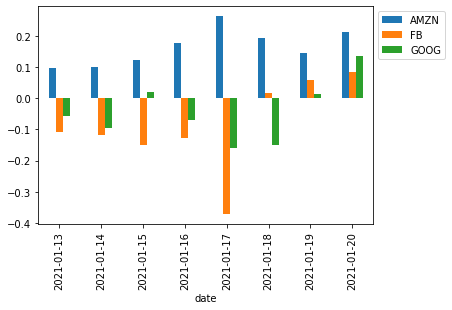

In [49]:
plt.figure(figsize=(20,16))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
# print(mean_df)

# .xs(), take cross-section to get rid of the 'compound' from groupby unstacking .unstack()
mean_df = mean_df.xs('compound', axis="columns").transpose()
print(mean_df)

mean_df.plot(kind='bar')

#place legend in top right corner
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

date    2021-01-13  2021-01-14  2021-01-15  2021-01-16  2021-01-17  \
ticker                                                               
AMZN      0.098300    0.101519    0.124184    0.177400    0.263350   
FB       -0.107527   -0.119364   -0.150991   -0.128071   -0.371200   
GOOG     -0.057520   -0.094742    0.018692   -0.068400   -0.159225   

date    2021-01-18  2021-01-19  2021-01-20  
ticker                                      
AMZN      0.193683    0.146886    0.211790  
FB        0.016765    0.059321    0.083227  
GOOG     -0.151250    0.015129    0.134671  


<Figure size 1440x1152 with 0 Axes>

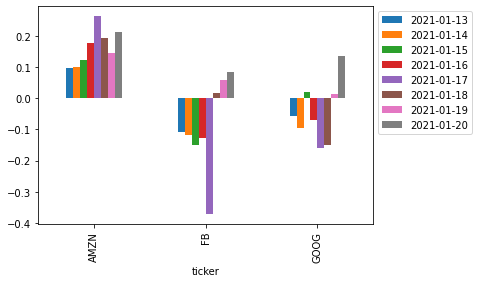

In [50]:
plt.figure(figsize=(20,16))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
# print(mean_df)

# .xs(), take cross-section to get rid of the 'compound' from groupby unstacking .unstack()
mean_df = mean_df.xs('compound', axis="columns")
print(mean_df)


mean_df.plot(kind='bar')

#place legend in top right corner
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()